# LLE Algorithm

## Import Libraries

In [4]:
import numpy as np
import pandas as pd

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.figsize'] = (6.5, 6.5)

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d

# plotting style
plt.style.use('classic')
plt.style.use('dark_background')
#plt.style.use('bmh')

import seaborn as sns

from IPython.display import Image

# display multiple outputs within a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all";

import warnings
warnings.filterwarnings('ignore');

## The Algorithm

**Algorithm Outline**: <br>
<br>
The Locally Linear Embedding algorithm has only one parameter k = number of nearest neighbors to consider, and then requires solving two optimization problems: <br>
<br>
Input - X , matrix with N observations in D dimensions <br>
Output - Y, matrix with N observations in d << D dimensions <br>
Parameter(s) = k, number of nearest neighbors to consider <br>
1. Find k nearest neighbors for each $X_i$ in X <br>
2. Solve for weights W to write each $X_i$ as linear combination of neighbors <br>
3. Compute lower dimensional embedding coordinates $Y_i$ that preserve local, linear relationships

## Step 1: Find k nearest neighbors

First, the parameter k must be defined to specify the number of nearest neighbors we use to linearly model $X_i$. There's no guaranteed way to know the optimal value of k before applying the algorithm, and different values of k along with different ways of defining the distance metric affect the performance of LLE. <br>
<br>
Here we show the effect of different values of k on LLE performed on a deformed sphere in 3D. We use the standard Euclidean distance metric from here on.

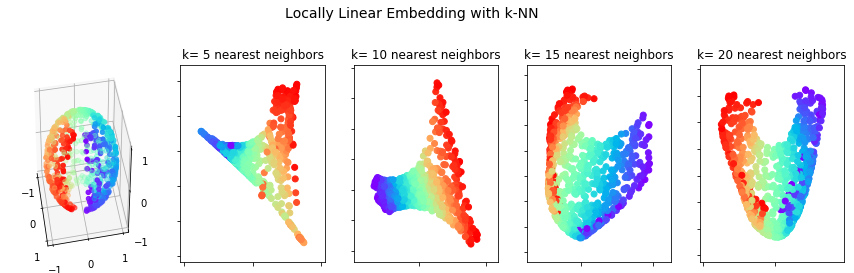

In [493]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

from sklearn import manifold
from sklearn.utils import check_random_state

# Variables for manifold learning.
n_samples = 1000

# Create our sphere.
random_state = check_random_state(0)
p = random_state.rand(n_samples) * (2 * np.pi - 0.55)
t = random_state.rand(n_samples) * np.pi

# Sever the poles from the sphere.
indices = ((t < (np.pi - (np.pi / 8))) & (t > ((np.pi / 8))))
colors = p[indices]
x, y, z = np.sin(t[indices]) * np.cos(p[indices]), \
    np.sin(t[indices]) * np.sin(p[indices]), \
    np.cos(t[indices])

# Plot our dataset.
fig = plt.figure(figsize=(15, 8))
plt.suptitle("Locally Linear Embedding with k-NN", fontsize=14)

ax = fig.add_subplot(251, projection='3d')
ax.scatter(x, y, z, c=p[indices], cmap=plt.cm.rainbow)
ax.view_init(40, -10)

sphere_data = np.array([x, y, z]).T

# Perform Locally Linear Embedding 
neighbors = np.arange(5, 25, 5)

for i, neighbor in enumerate(neighbors):
    trans_data = manifold.LocallyLinearEmbedding(neighbor, 2).fit_transform(sphere_data).T
    
    ax = fig.add_subplot(252 + i)
    plt.scatter(trans_data[0], trans_data[1], c=colors, cmap=plt.cm.rainbow);
    ax.xaxis.set_major_formatter(NullFormatter());
    ax.yaxis.set_major_formatter(NullFormatter());
    plt.title('k= ' +str(neighbor) + ' nearest neighbors')
    plt.axis('tight');
plt.show();

## Step 2: Linearly weighted combination of k-NN

**Step 2**: Define each data point $X_i$ in terms of its local linear relationships. <br>  
We have to define a parameter k to specify the number of nearest neighbors we consider. Then, for each $X_i$ in dimension D, we reconstruct $X_i$ using a linear combination of its k nearest neighbors. <br>
<br>
**Note**: this linear combination reconstruction is also in dimension D.  

For each point $X_i$ we define a linear combination with the weight matrix $W$ and its nearest neighbors $X_j$. <br> We have the total reconstruction error defined by cost function: 

$$\mathcal{E}(W) = \sum_{i} ||X_i - \sum_{j} W_{ij} X_j||^2$$

This has a residual sum of squares form where we have the error as the Euclidean distance between the original $X_i$ and our nearest neighbors construction

For our weight matrix W, we have

$$\mathbf{W} = \begin{bmatrix}
w_{11} & w_{12} & \cdots & w_{1n} \\
w_{21} & w_{22} & \cdots & w_{2n} \\
\vdots & \vdots & \vdots & \vdots \\
w_{n1} & w_{n2} & \cdots & w_{nn}
\end{bmatrix}$$ <br>
<br>
where for some $X_i$ we have the linear combination $\sum_{j} W_{ij} X_j = w_{i1} X_{1} + \cdots + w_{in} X_{n}$ 

We have two constraints on $W$: <br>
- $W_{ij} = 0$ if $X_{j}$ not one of the nearest neighbors for a given $X_i$ (we only consider the local neighborhood) <br>
- The rows of the weight matrix sum to one: $\sum_{j} W_{ij} = 1$ (a constraint that becomes helpful for solving optimization problem)

We define this in terms of the constrained optimization problem:

\begin{equation*}
\begin{aligned}
& \underset{W}{\text{min}}
& & \mathcal{E}(W) = \sum_{i} ||X_i - \sum_{j} W_{ij} X_j||^2 \\
\end{aligned}
\end{equation*}

Now we show an example illustrating the reconstruction by linear weights of local neighbors.

### Ex.) Linear combination of local neighborhood

Using the 'S' curve from before, we have the following 3D dataset.

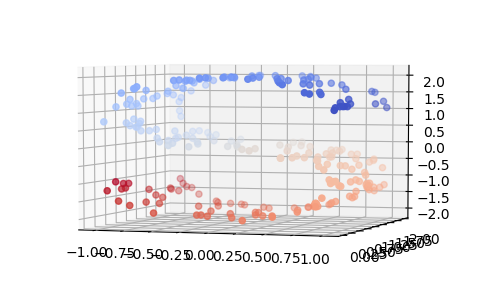

In [468]:
from sklearn.datasets.samples_generator import make_s_curve
plt.style.use('default')
data, color = make_s_curve(250, random_state=0)
fig = plt.figure(figsize = (6, 8))
ax = fig.add_subplot(211, projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=color, cmap=plt.cm.coolwarm)
ax.view_init(4, -72);

From the example above, we have a dataset that we take to be an embedded 2D manifold in this higher dimensional 3D space. We consider a local neighborhood and visualize how we can use linear combinations to represent the intrinsic geometry.

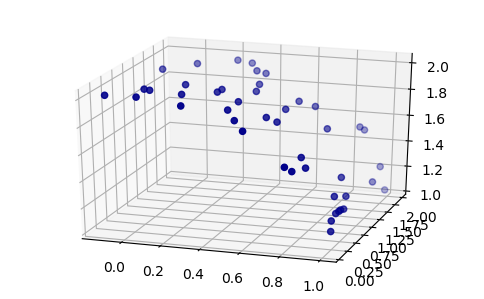

In [469]:
fig = plt.figure(figsize = (6, 8))
ax = fig.add_subplot(211, projection='3d')
neighborhood1 = data[color < -3]
ax.scatter(neighborhood1[:, 0], neighborhood1[:, 1], neighborhood1[:, 2], c='darkblue')
ax.view_init(24, -72);

In this neighborhood the data can be reasonably approximately as lying close to a 2D plane. <br>
The plane that minimizes the information lost in this projection can be found by using Principal Component Analysis for this local neighborhood.

In [470]:
# center around the mean
X = neighborhood1
X_centered = X - X.mean(axis=0)
X = X_centered

# project onto first two principal axes with sklearn
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

X3D_inv = pca.inverse_transform(X2D)

In [471]:
# equations to define the plane
axes = [-1.0, 1.0, -1.0, 1.0, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

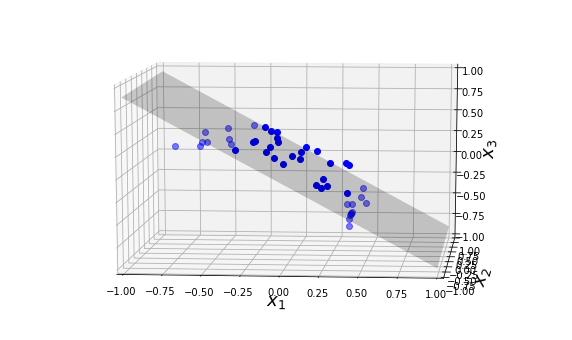

In [472]:
%matplotlib inline
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
m, n = X.shape

#for i in range(m):
#    if X[i, 2] > X3D_inv[i, 2]:
#        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k--")
#    else:
#        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k--", color="#505050")
    
#ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
#ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
ax.view_init(10, 275)
plt.show();

Consider a different local neighborhood of the 'S' curve, denoted in red. We describe the local, linear relationships of this neighborhood in the same way.

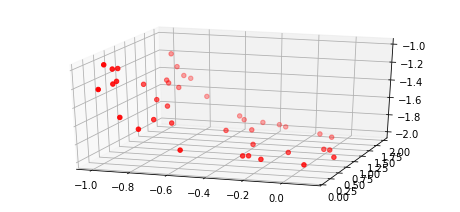

In [473]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(211, projection='3d')
neighborhood2 = data[color > 3]
ax.scatter(neighborhood2[:, 0], neighborhood2[:, 1], neighborhood2[:, 2], c='red')
ax.view_init(24, -72);

In this neighborhood the data can be reasonably approximately as lying close to a 2D plane.

In [475]:
# center around the mean
X = neighborhood2
X_centered = X - X.mean(axis=0)
X = X_centered

# first two principal components
pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

X3D_inv = pca.inverse_transform(X2D)

In [476]:
# equations to define the plane
axes = [-1.0, 1.0, -1.0, 1.0, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

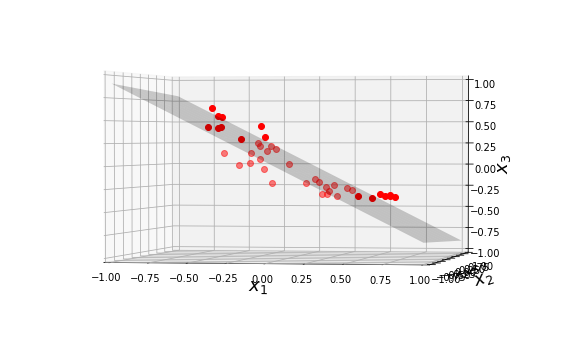

In [477]:
%matplotlib inline
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "ro", alpha=0.5)
ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "ro")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
ax.view_init(1, 280)
plt.show();

Continuing on in this way, we can see that Local Linear Embedding is very similar to a collection of local principal component projections that globally combine to define a non-linear embedding. <br>
<br>
We imagine locally linear patches in the manifold, and although the data is globally non-linear, we "learn" these locally linear representations of the data.

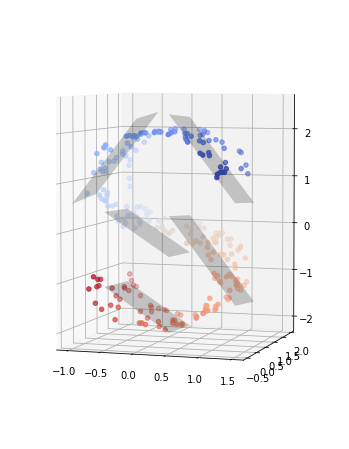

In [478]:
# plot example local patches
fig = plt.figure(figsize = (6, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=color, cmap=plt.cm.coolwarm)
ax.plot_surface(x1 / 2, x2 / 2, z / 2, alpha=0.2, color="k")
ax.plot_surface(x1 / 2, x2 / 2, z / 2 - 1.5, alpha=0.2, color="k")
ax.plot_surface((x1 + 2) / 2, x2 / 2, z-0.5, alpha=0.2, color="k")
ax.plot_surface((x1 - 1) / 2, x2 / 2, - z + 1.5, alpha=0.2, color="k")
ax.plot_surface((x1 + 2) / 2, x2 / 2, z + 1.5, alpha=0.2, color="k")
ax.view_init(4, -72);

We can also points in this 3D space defined as linear combinations of the k nearest neighbors.

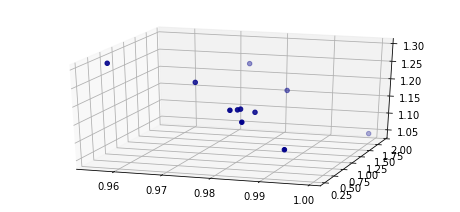

In [461]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(211, projection='3d')
neighborhood = data[color < -3]
neighborhood = neighborhood[neighborhood[:, 2] < 1.5]
neighborhood = neighborhood[neighborhood[:, 0] > 0.94]
ax.scatter(neighborhood[:, 0], neighborhood[:, 1], neighborhood[:, 2], c='darkblue')
ax.view_init(24, -72);

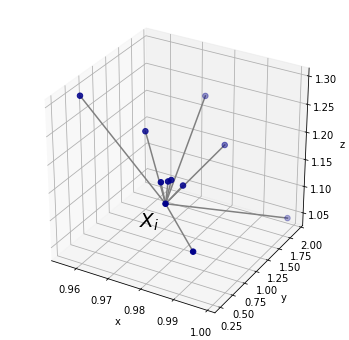

In [462]:
fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(111, projection='3d')
neighborhood = data[color < -3]
neighborhood = neighborhood[neighborhood[:, 2] < 1.5]
neighborhood = neighborhood[neighborhood[:, 0] > 0.94]
ax.scatter(neighborhood[:, 0], neighborhood[:, 1], neighborhood[:, 2], c='darkblue', s=30)

for i in range(len(neighborhood)):
    ax.plot(neighborhood[[6,i], 0], neighborhood[[6,i], 1], neighborhood[[6,i], 2], c='gray')

ax.text(neighborhood[6, 0], neighborhood[6, 1] - 0.5, neighborhood[6, 2], s='$X_i$', size=20)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

### Ex.) Invariance to rotation, scaling, translation

By the way we defined the cost function, the optimal weights are invariant to rotation, scaling, and translation, so they reflect intrinsic geometric properties of the original data space. <br>
<br>
There exists an approximately linear mapping (translation, rotation, and rescaling) that maps $X_i$ to the lower dimensional manifold. Therefore, since the weights are invariant, these same optimal weights that reconstruct $X_i$ in D dimensions (as described above), also reconstruct the embedded manifold coordinates of $X_i$ in d dimensions.

***

### Constrained Optimization : Finding Weights with Constrained Least Squares

**Constrined Least Squares Problem** <br>
<br>
Find weights that minimize $$\mathcal{E}(W) = \sum_{i} ||X_i - \sum_{j} W_{ij} X_j||^2$$
subject to the constraints: <br>
- $W_{ij} = 0$ if $X_{j}$ not one of the nearest neighbors for a given $X_i$ (we only consider the local neighborhood) <br>
- The rows of the weight matrix sum to one: $\sum_{j} W_{ij} = 1$

Consider error for a particular $X_i$:  $$\mathcal{E}_i = ||X_i - \sum_{j} W_{ij} X_j||^2$$
and since sum of weights = 1, we have $$\mathcal{E}_i = ||\sum_{j} W_{ij}X_i - \sum_{j} W_{ij} X_j||^2$$
after factoring: $$\mathcal{E}_i = ||\sum_{j} W_{ij} (X_i - X_j)||^2$$

Since this quantity is squared we can swap the order of $X_i$ and $X_j$ <br>: $$\mathcal{E}_i = ||\sum_{j} W_{ij} (X_j - X_i)||^2$$

Let $z_j = x_j - x_i$, and with k neighbors $\mathbf{z}$ is the k x p matrix with rows <br>
<br>
$$\mathbf{z} = \begin{bmatrix}
z_{1} = x_{1} - x_{i} \\
z_{2} = x_{2} - x_{i} \\
\vdots & \\
z_{k} = x_{k} - x_{i} 
\end{bmatrix}$$

and $w_i$ is the k x 1 matrix with weights for each neighbor of $x_i$. <br>
<br>
$$\mathbf{w_i} = \begin{bmatrix}
w_{i1} \\
w_{i2} \\
\vdots & \\
w_{ik}  
\end{bmatrix}$$

Therefore <br>

\begin{equation}
\begin{aligned}
\mathcal{E}_i & = ||\sum_{j} W_{ij} (X_j - X_i)||^2\\
\\
            & = ||\sum_{j} W_{ij} Z_j||^2\\
\\
            & = ||w_{i1} z_1 + ... + w_{ik} z_k||^2\\
\\
            & = ||w_{i}^{T} z||^2\\
\\
            & = w_{i}^{T} z z^{T} w_{i}\\
\end{aligned}
\end{equation}

Note: the last line follows from $||\mathbf{v}||^2 = \mathbf{v}^T \mathbf{v}$ and $(w_{i}^{T} z) ^ T = z^{T} w_{i}$

**Definition** - $zz^{T}$ is the **Gram matrix** which is symmetric, positive semi-definite k x k matrix containing inner products of pairwise differences <br>
<br>
For $X_i$ with nearest neighbors $X_1, ..., X_k$: $$G_{jk} = \langle\ X_i - X_j, X_i - X_k \rangle$$  

***
**Lagrange Multiplier Problem**

We set up langrange multiplier problem with $\mathbf{1}^T$ as the k x 1 matrix of all 1's so <br> $$\mathbf{1}^T w = \mathbf{1}$$ represents our constraint that the weights sum to 1.

$$\mathcal{L}(w_i, \lambda) = w_{i}^{T} G_i w_{i} - \lambda(\mathbf{1}^T w - \mathbf{1}) = 0$$

\begin{equation}
\frac{\partial \mathcal{L}}{\partial w_i} = 2G_i w_i - \lambda \mathbf{1} = 0 \\
\\
\frac{\partial \mathcal{L}}{\partial \lambda} = \mathbf{1}^T w_i - \mathbf{1} = 0
\end{equation}

From the first partial derivative: <br>
<br>
$$2G_i w_i = \lambda \mathbf{1} $$

And if Gram matrix G is invertible, we have a closed form to compute the optimal weights: <br>
<br>
$$\boxed {w_i = \frac{\lambda}{2} G_{i}^{-1} \mathbf{1}}$$

***

**Note:** <br>
<br>
We find the optimal weights for each point separately

**Note:**

G represents a local covariance matrix of distances and we index over all pairs of points in the local neighborhood with $X_j \ , X_k$ as local neighbors and <br>
<br>
$$G_{jk} = (X_i - X_j) \cdot (X_i - X_k)$$

Covariance is invariant to linear transformations and this illustrates why the optimal weights remain constant under rescaling, rotation, and translation. <br>
<br>
$$Cov(X_i, X_j) = \frac{\sum (X_i - \mu_i) (X_j - \mu_j)}{n}$$ <br>

**Note:** If problem ill-conditioned (K > D), can add by small multiple of identity matrix

## Step 3: Map to lower dimensional space

**Step 2**: Construct the mapping from each $X_i$ in D to its lower dimensional manifold representation $Y_i$ in d. <br>  
Since the optimal weights we found have certain invariant properties, we use these weights in this mapping. We define a new cost function with a similar form to the previous one, where we want to minimize reconstruction error

$$\phi(Y) = \sum_{i} ||Y_i - \sum_{j} (W_{ij} Y_j)||^2$$

This time, we fix the weights and find optimal coordinates $Y_i$ <br>
<br>

***

### Eigenvalue Problem: Optimal Embedding Coordinates

**Eigenvalue Problem** <br>
<br>
We seek $Y_i$ in dimension d that minimize the embedding cost function: <br> 
<br>
$$\phi(Y) = \sum_{i} ||Y_i - \sum_{j} (W_{ij} Y_j)||^2$$
where $W_{ij}$ are fixed and we have constraints on the output coordinates: 
- $\sum_i Y_i = 0$ (centered on the origin, translational degree of freedom)<br>
- $\frac{1}{N} \sum_i Y_i Y_i^T = \mathbf{I}$ (unit covariance, rotational degree of freedom)
<br>
<br>
We have constraint of unit covariance (which is related to eigenvectors being orthonormal) and that the mean is zero

***

![title](lle2.png)

![title](lle3.png)

By the last line, Y is an eigenvector and so to minimize 
$$\phi(Y) = Y^{T} M Y$$ <br>
we choose the bottom d+1 eigenvectors (smallest eigenvalues) of M as our coordinates on the manifold.

**Note**: matrix trace properties like similarity invariant, matrix product, quadratic forms

\begin{equation}
\begin{aligned}
tr(A^T B) & = tr(B^T A)\\
\\
            & = tr(A B^T)\\
\\
            & = tr(B A^T)\\
\\
            & = \sum_{i, j} A_{i,j} B_{i,j}\\
\end{aligned}
\end{equation}